## Boston Housing Price Prediction

In [2]:
import mlflow

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
print("Successfully set MLFlow Server Path")

Successfully set MLFlow Server Path


## Step 1: Load the boston housing dataset

In [73]:
from src.models.boston_house_price_prediction import train_model
from src.models.boston_house_price_prediction import env
import os
from pathlib import Path


from dotenv import find_dotenv
from dotenv import load_dotenv


# Define the filename for the resulting model
model_filename = 'boston_housing_price_predictor.pkl'
boston_dataset_url = "http://lib.stat.cmu.edu/datasets/boston"
boston_dataset = "boston_dataset.csv"


# Load environment variables from the .env file
env_file = find_dotenv(".env")
environ = load_dotenv(env_file)

# Access the environment variables
project_root = os.environ.get('PROJECT_ROOT_FOLDER')
if not project_root:
    raise ValueError("PROJECT_ROOT environment variable is not set.")
absolute_path = os.path.abspath(project_root)
data_dir = Path(os.path.join(absolute_path, 'data/raw/boston_housing_price/'))
models_dir = Path(os.path.join(absolute_path, 'models/boston_housing_price/'))
print('***************** LOAD ENVIRONMENT ********************+')
print("Project Root DIR", project_root)
print("Project Abs DIR", absolute_path)
print("Project Data DIR", data_dir)
print("Models Dump DIR", models_dir)
print('***************** LOAD ENVIRONMENT ********************+')
dataset_file = os.path.join(data_dir, env.boston_dataset)
print(dataset_file)

boston = train_model.load_data(data_dir=env.data_dir)

***************** LOAD ENVIRONMENT ********************+
Project Root DIR ../
Project Abs DIR /home/joesan/Projects/Private/ml-projects/nn-playground
Project Data DIR /home/joesan/Projects/Private/ml-projects/nn-playground/data/raw/boston_housing_price
Models Dump DIR /home/joesan/Projects/Private/ml-projects/nn-playground/models/boston_housing_price
***************** LOAD ENVIRONMENT ********************+
/home/joesan/Projects/Private/ml-projects/nn-playground/data/raw/boston_housing_price/boston_dataset.csv


OSError: Cannot save file into a non-existent directory: '../nn-playground/data/raw/boston_housing_price'

In [72]:
# Let us visualize the dataset
import pandas as pd

pd.DataFrame(boston.data).head()

NameError: name 'boston' is not defined

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [27]:
urls = train_model.search_images('bird photos', max_images=10)
print(urls[0])

Searching for 'bird photos'
https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg


...and then download a URL and take a look at it:

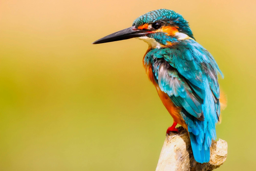

In [28]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=false)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

Searching for 'forest photos'


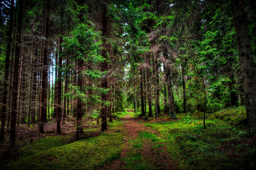

In [29]:
download_url(train_model.search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab 200 examples of each of "bird" and "forest" photos, and save each group of photos to a different folder:

In [16]:
# Let us now fetch roughly 200 images of forests and birds 
train_model.fetch_images

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [18]:
train_model.unlink_failed_images

0

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

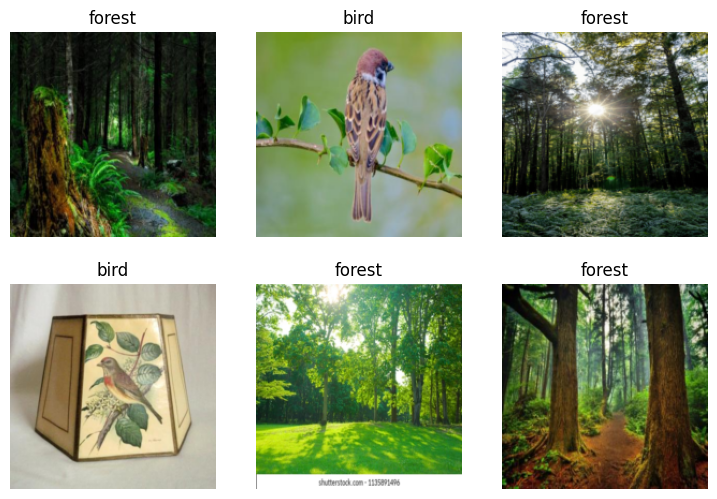

In [19]:
dls = train_model.dls
dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [20]:
learn = train_model.train_model_from_data()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/joesan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 29.9MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.029642,2.269074,0.529412,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.382435,0.534057,0.205882,00:12
1,0.226671,0.068475,0.029412,00:11
2,0.157894,0.009568,0.000000,00:12


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [25]:
is_bird,_,probs = learn.predict(PILImage.create('forest.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: forest.
Probability it's a bird: 0.0008


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

In [ ]:
import joblib
joblib.dump(learn, 'is_it_a_bird.pkl')

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.